In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob
import molvs
from multiprocessing import Pool, cpu_count
from tqdm.auto import tqdm

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/7wf5/molsnapper/use_pharma_false
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/7wf5/molsnapper


Reading data from crossdock dataset, add a standardization for small molecule data:

In [3]:
standardizer = molvs.standardize.Standardizer()

def standardize_mol(mol):
    try:
        mol = standardizer.standardize(mol)
        mol = standardizer.fragment_parent(mol, skip_standardize=True)
        mol = standardizer.tautomer_parent(mol, skip_standardize=True)
        mol = standardizer.isotope_parent(mol, skip_standardize=True)
        mol = standardizer.charge_parent(mol, skip_standardize=True)
        return mol
    except:
        return None

In [4]:
smi_list = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/7wf5/molsnapper/use_pharma_false/500_generated.smi') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in tqdm(smi_list, desc="Standardizing molecules", unit="mol"):
    mol = Chem.MolFromSmiles(smi)
    mol = standardize_mol(mol)
    
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))
    else:
        print(f"Skipping molecule {smi}")
        pass

print(len(smi_list))
len(standardized_smiles_list)

Standardizing molecules:   0%|          | 0/506 [00:00<?, ?mol/s]

[16:30:16] Can't kekulize mol.  Unkekulized atoms: 0 2 3
[16:30:16] Can't kekulize mol.  Unkekulized atoms: 0 2 3
[16:30:16] Can't kekulize mol.  Unkekulized atoms: 0 2 3


506


506

Set the default image size

In [5]:
with open('500_generated_standardized.smi', 'w') as f:
    for item in standardized_smiles_list:
        f.write("%s\n" % item)

In [6]:
uru.rd_set_image_size(300,300)

Convert SMILES and name of them to a dataframe

In [7]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

,SMILES
0,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...
1,Cc1ccc(C(=O)NC2CC3C4C(C2)N4C(N2CCN(C)CC2)CC3C(...
2,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...
3,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)F...
4,Cc1ccc(C(=O)N=Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F...
...,...
501,Cc1ccc(C(=O)Nc2ccc(OC(C=O)N3CCN(C)CC3)c(C(F)(F...
502,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)F...
503,COc1ccc(C(=O)Nc2ccc(NC(=O)N3CCN(C)CC3)c(C(F)(F...
504,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...


Remove repeated molecules

In [8]:
df = df.drop_duplicates(['SMILES'])
df.reset_index(inplace=True, drop=True)
df

,SMILES
0,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...
1,Cc1ccc(C(=O)NC2CC3C4C(C2)N4C(N2CCN(C)CC2)CC3C(...
2,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)F...
3,Cc1ccc(C(=O)N=Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F...
4,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...
...,...
253,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...
254,CN1CCN(Cc2ccc(NC(=O)c3ccc4c(c3)c(C=Cc3cnc5cccc...
255,CC1CN(C)CCN1C(=O)c1ccc(NC(=O)C2CCC3(CO3)C(C3=[...
256,Cc1ccc(C(=O)Nc2ccc(NC(=O)[N+]3(C)CCN(C)CC3)c(C...


Save the smi file for further use

Add an RDKit molecule to the dataframe

In [9]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

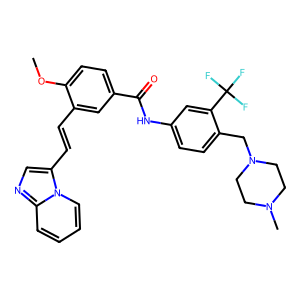

In [10]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [11]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0          [c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]
1      [c1ccccc1, C1CC2CCCN3C(C1)C23, C1CNCCN1, c1ccn...
2          [c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]
3          [c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]
4          [c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]
                             ...                        
253    [c1ccccc1, c1ccccc1, C1CNCCN1, C1=[N+]=C1, c1c...
254    [C1CNCCN1, c1ccccc1, c1ccc2[nH]ccc2c1, c1ccn2c...
255    [C1CNCCN1, c1ccccc1, C1CCC2(CC1)CO2, C1=[N+]=C...
256    [c1ccccc1, c1ccccc1, C1C[NH2+]CCN1, c1ccn2ccnc...
257       [c1ccccc1, c1ccccc1, C1CNCCN1, C1CCN2CCCNC2C1]
Name: ring_sytems, Length: 258, dtype: object

In [12]:
df.ring_sytems.values

array([list(['c1ccccc1', 'c1ccccc1', 'C1CNCCN1', 'c1ccn2ccnc2c1']),
       list(['c1ccccc1', 'C1CC2CCCN3C(C1)C23', 'C1CNCCN1', 'c1ccn2ccnc2c1']),
       list(['c1ccccc1', 'c1ccccc1', 'C1CNCCN1', 'c1ccn2ccnc2c1']),
       list(['c1ccccc1', 'c1ccccc1', 'C1CNCCN1', 'c1ccn2ccnc2c1']),
       list(['c1ccccc1', 'c1ccccc1', 'C1CNCCN1', 'c1ccn2ccnc2c1']),
       list(['c1ccccc1', 'N=C1C=CC2C3=C1C32', 'C1CNCCN1', 'c1ccn2ccnc2c1']),
       list(['C1CNCCN1', 'c1ccccc1', 'c1ccc2c3c(c[nH+]c2c1)C3=C1CNC2CCCCN12']),
       list(['c1ccccc1', 'c1ccccc1', 'C1CNCCN1', 'c1ccn2ccnc2c1']),
       list(['c1ccccc1', 'c1ccccc1', 'C1CNCCN1', 'c1ccn2ccnc2c1']),
       list(['C1CNCCN1', 'c1ccccc1', 'c1cc2c3c-2cccc3c1', 'c1ccn2ccnc2c1']),
       list(['C1CNCCN1', 'c1ccccc1', 'c1cc2c3c-2cccc3c1', 'C=C1CNC2CCCCN12']),
       list(['c1ccccc1', 'N=c1c2ccccc12', 'C1CNCCN1', 'c1ccn2ccnc2c1']),
       list(['C=C=C1c2ccccc21', 'c1ccccc1', 'C1CNCCN1', 'c1ccn2ccnc2c1']),
       list(['C1CNCCN1', 'c1ccccc1', 'c1cc2c3c-2cccc3

See how many times each ring system occurs

In [13]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
0,c1ccccc1,365
1,C1CNCCN1,223
2,c1ccn2ccnc2c1,197
7,C=C1CNC2CCCCN12,32
29,c1ccc2[nH]ccc2c1,17
...,...,...
56,c1ccc2cnncc2c1,1
57,C=[N+]=C1CCc2ccccc21,1
62,O=c1c[nH+]1,1
63,C1=c2ccccc2=NCC1,1


View the ring system frequencies

In [14]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [15]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

In [16]:
res

0      [(c1ccccc1, 2568039), (c1ccccc1, 2568039), (C1...
1      [(c1ccccc1, 2568039), (C1CC2CCCN3C(C1)C23, 0),...
2      [(c1ccccc1, 2568039), (c1ccccc1, 2568039), (C1...
3      [(c1ccccc1, 2568039), (c1ccccc1, 2568039), (C1...
4      [(c1ccccc1, 2568039), (c1ccccc1, 2568039), (C1...
                             ...                        
253    [(c1ccccc1, 2568039), (c1ccccc1, 2568039), (C1...
254    [(C1CNCCN1, 161505), (c1ccccc1, 2568039), (c1c...
255    [(C1CNCCN1, 161505), (c1ccccc1, 2568039), (C1C...
256    [(c1ccccc1, 2568039), (c1ccccc1, 2568039), (C1...
257    [(c1ccccc1, 2568039), (c1ccccc1, 2568039), (C1...
Name: mol, Length: 258, dtype: object

In [17]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq
0,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d34820>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064
1,Cc1ccc(C(=O)NC2CC3C4C(C2)N4C(N2CCN(C)CC2)CC3C(...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36d50>,"[c1ccccc1, C1CC2CCCN3C(C1)C23, C1CNCCN1, c1ccn...",C1CC2CCCN3C(C1)C23,0
2,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35b60>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064
3,Cc1ccc(C(=O)N=Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35e70>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064
4,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36ce0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064
...,...,...,...,...,...
253,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4510>,"[c1ccccc1, c1ccccc1, C1CNCCN1, C1=[N+]=C1, c1c...",C1=[N+]=C1,0
254,CN1CCN(Cc2ccc(NC(=O)c3ccc4c(c3)c(C=Cc3cnc5cccc...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4580>,"[C1CNCCN1, c1ccccc1, c1ccc2[nH]ccc2c1, c1ccn2c...",c1ccn2ccnc2c1,13064
255,CC1CN(C)CCN1C(=O)c1ccc(NC(=O)C2CCC3(CO3)C(C3=[...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab45f0>,"[C1CNCCN1, c1ccccc1, C1CCC2(CC1)CO2, C1=[N+]=C...",C1=[N+]=C1,0
256,Cc1ccc(C(=O)Nc2ccc(NC(=O)[N+]3(C)CCN(C)CC3)c(C...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4660>,"[c1ccccc1, c1ccccc1, C1C[NH2+]CCN1, c1ccn2ccnc...",C1C[NH2+]CCN1,509


In [18]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [19]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[16:32:44] WARNING: Omitted undefined stereo

[16:32:44] WARNING: Omitted undefined stereo

[16:32:44] WARNING: Omitted undefined stereo

[16:32:44] WARNING: Omitted undefined stereo

[16:32:44] WARNING: Omitted undefined stereo

[16:32:44] WARNING: Omitted undefined stereo

[16:32:44] WARNING: Proton(s) added/removed; Omitted undefined stereo

[16:32:44] WARNING: Omitted undefined stereo

[16:32:44] WARNING: Omitted undefined stereo

[16:32:44] WARNING: Omitted undefined stereo

[16:32:44] WARNING: Omitted undefined stereo

[16:32:44] WARNING: Omitted undefined stereo

[16:32:44] WARNING: Omitted undefined stereo

[16:32:44] WARNING: Omitted undefined stereo

[16:32:44] WARNING: Omitted undefined stereo

[16:32:44] WARNING: Omitted undefined stereo

[16:32:44] WARNING: Omitted undefined stereo

[16:32:44] WARNING: Omitted undefined stereo

[16:32:44] WARNING: Proton(s) added/removed; Omitted undefined stereo

[16:32:44] WARNING: Omitted undefined stereo

[16:32:44] WARNING: Omitted un

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d34820>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H30F3N5O2/c1-36-13-15-37(16-14-36)...
1,Cc1ccc(C(=O)NC2CC3C4C(C2)N4C(N2CCN(C)CC2)CC3C(...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36d50>,"[c1ccccc1, C1CC2CCCN3C(C1)C23, C1CNCCN1, c1ccn...",C1CC2CCCN3C(C1)C23,0,InChI=1S/C32H37F3N6O/c1-20-6-7-22(15-21(20)8-9...
2,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35b60>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H29F3N6O2/c1-20-6-7-21(17-26(20)34...
3,Cc1ccc(C(=O)N=Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35e70>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H27F3N6O2/c1-20-6-7-22(17-21(20)8-...
4,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36ce0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H28F3N5O3/c1-36-13-15-37(16-14-36)...
...,...,...,...,...,...,...
253,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4510>,"[c1ccccc1, c1ccccc1, C1CNCCN1, C1=[N+]=C1, c1c...",C1=[N+]=C1,0,InChI=1S/C30H27F3N6O2/c1-37-11-13-38(14-12-37)...
254,CN1CCN(Cc2ccc(NC(=O)c3ccc4c(c3)c(C=Cc3cnc5cccc...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4580>,"[C1CNCCN1, c1ccccc1, c1ccc2[nH]ccc2c1, c1ccn2c...",c1ccn2ccnc2c1,13064,InChI=1S/C32H31F3N6O/c1-38-13-15-40(16-14-38)2...
255,CC1CN(C)CCN1C(=O)c1ccc(NC(=O)C2CCC3(CO3)C(C3=[...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab45f0>,"[C1CNCCN1, c1ccccc1, C1CCC2(CC1)CO2, C1=[N+]=C...",C1=[N+]=C1,0,InChI=1S/C31H31F3N6O3/c1-18-16-38(2)11-12-39(1...
256,Cc1ccc(C(=O)Nc2ccc(NC(=O)[N+]3(C)CCN(C)CC3)c(C...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4660>,"[c1ccccc1, c1ccccc1, C1C[NH2+]CCN1, c1ccn2ccnc...",C1C[NH2+]CCN1,509,InChI=1S/C31H31F3N6O3/c1-20-7-10-24(28(41)23(2...


How many of them have ring system?

In [20]:
df_ring = df[df.min_freq != -1]
df_ring

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d34820>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H30F3N5O2/c1-36-13-15-37(16-14-36)...
1,Cc1ccc(C(=O)NC2CC3C4C(C2)N4C(N2CCN(C)CC2)CC3C(...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36d50>,"[c1ccccc1, C1CC2CCCN3C(C1)C23, C1CNCCN1, c1ccn...",C1CC2CCCN3C(C1)C23,0,InChI=1S/C32H37F3N6O/c1-20-6-7-22(15-21(20)8-9...
2,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35b60>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H29F3N6O2/c1-20-6-7-21(17-26(20)34...
3,Cc1ccc(C(=O)N=Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35e70>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H27F3N6O2/c1-20-6-7-22(17-21(20)8-...
4,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36ce0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H28F3N5O3/c1-36-13-15-37(16-14-36)...
...,...,...,...,...,...,...
253,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4510>,"[c1ccccc1, c1ccccc1, C1CNCCN1, C1=[N+]=C1, c1c...",C1=[N+]=C1,0,InChI=1S/C30H27F3N6O2/c1-37-11-13-38(14-12-37)...
254,CN1CCN(Cc2ccc(NC(=O)c3ccc4c(c3)c(C=Cc3cnc5cccc...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4580>,"[C1CNCCN1, c1ccccc1, c1ccc2[nH]ccc2c1, c1ccn2c...",c1ccn2ccnc2c1,13064,InChI=1S/C32H31F3N6O/c1-38-13-15-40(16-14-38)2...
255,CC1CN(C)CCN1C(=O)c1ccc(NC(=O)C2CCC3(CO3)C(C3=[...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab45f0>,"[C1CNCCN1, c1ccccc1, C1CCC2(CC1)CO2, C1=[N+]=C...",C1=[N+]=C1,0,InChI=1S/C31H31F3N6O3/c1-18-16-38(2)11-12-39(1...
256,Cc1ccc(C(=O)Nc2ccc(NC(=O)[N+]3(C)CCN(C)CC3)c(C...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4660>,"[c1ccccc1, c1ccccc1, C1C[NH2+]CCN1, c1ccn2ccnc...",C1C[NH2+]CCN1,509,InChI=1S/C31H31F3N6O3/c1-20-7-10-24(28(41)23(2...


In [21]:
filtered_df_ring_freq = df[df.min_freq > 100]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d34820>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H30F3N5O2/c1-36-13-15-37(16-14-36)...
2,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35b60>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H29F3N6O2/c1-20-6-7-21(17-26(20)34...
3,Cc1ccc(C(=O)N=Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35e70>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H27F3N6O2/c1-20-6-7-22(17-21(20)8-...
4,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36ce0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H28F3N5O3/c1-36-13-15-37(16-14-36)...
7,Cc1ccc(C(=O)Nc2ccc(NC(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35a10>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H30F3N7O2/c1-20-6-7-21(17-26(20)34...
...,...,...,...,...,...,...
247,Cc1ccc(C(=O)Nc2ccc(OC(C=O)N3CCN(C)CC3)c(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4270>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C31H30F3N5O3/c1-21-6-7-23(17-22(21)8-...
248,CN1CCN(C(=O)c2ccc(NC(=O)NC3CCC4(CO4)C(C=Cc4cnc...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab42e0>,"[C1CNCCN1, c1ccccc1, C1CCC2(CC1)CO2, c1ccn2ccn...",C1CCC2(CC1)CO2,104,InChI=1S/C30H33F3N6O3/c1-37-12-14-38(15-13-37)...
252,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab44a0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H29F3N6O3/c1-37-13-15-38(16-14-37)...
254,CN1CCN(Cc2ccc(NC(=O)c3ccc4c(c3)c(C=Cc3cnc5cccc...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4580>,"[C1CNCCN1, c1ccccc1, c1ccc2[nH]ccc2c1, c1ccn2c...",c1ccn2ccnc2c1,13064,InChI=1S/C32H31F3N6O/c1-38-13-15-40(16-14-38)2...


### How many of them could pass PAINS filter?

Get a list of rules

In [22]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [23]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [24]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [25]:
reos.pandas_mols(df.mol)

  0%|          | 0/258 [00:00<?, ?it/s]

,rule_set_name,description
0,ok,ok
1,ok,ok
2,ok,ok
3,PAINS,azo_A(324)
4,ok,ok
...,...,...
253,ok,ok
254,ok,ok
255,ok,ok
256,ok,ok


In [26]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/258 [00:00<?, ?it/s]

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,rule_set_name,description
0,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d34820>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H30F3N5O2/c1-36-13-15-37(16-14-36)...,ok,ok
1,Cc1ccc(C(=O)NC2CC3C4C(C2)N4C(N2CCN(C)CC2)CC3C(...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36d50>,"[c1ccccc1, C1CC2CCCN3C(C1)C23, C1CNCCN1, c1ccn...",C1CC2CCCN3C(C1)C23,0,InChI=1S/C32H37F3N6O/c1-20-6-7-22(15-21(20)8-9...,ok,ok
2,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35b60>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H29F3N6O2/c1-20-6-7-21(17-26(20)34...,ok,ok
4,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36ce0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H28F3N5O3/c1-36-13-15-37(16-14-36)...,ok,ok
5,COc1ccc(C(=O)N=C2C=C(C(F)(F)F)C3(NC(=O)N4CCN(C...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d37290>,"[c1ccccc1, N=C1C=CC2C3=C1C32, C1CNCCN1, c1ccn2...",N=C1C=CC2C3=C1C32,0,InChI=1S/C31H27F3N6O3/c1-38-11-13-39(14-12-38)...,ok,ok
...,...,...,...,...,...,...,...,...
253,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4510>,"[c1ccccc1, c1ccccc1, C1CNCCN1, C1=[N+]=C1, c1c...",C1=[N+]=C1,0,InChI=1S/C30H27F3N6O2/c1-37-11-13-38(14-12-37)...,ok,ok
254,CN1CCN(Cc2ccc(NC(=O)c3ccc4c(c3)c(C=Cc3cnc5cccc...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4580>,"[C1CNCCN1, c1ccccc1, c1ccc2[nH]ccc2c1, c1ccn2c...",c1ccn2ccnc2c1,13064,InChI=1S/C32H31F3N6O/c1-38-13-15-40(16-14-38)2...,ok,ok
255,CC1CN(C)CCN1C(=O)c1ccc(NC(=O)C2CCC3(CO3)C(C3=[...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab45f0>,"[C1CNCCN1, c1ccccc1, C1CCC2(CC1)CO2, C1=[N+]=C...",C1=[N+]=C1,0,InChI=1S/C31H31F3N6O3/c1-18-16-38(2)11-12-39(1...,ok,ok
256,Cc1ccc(C(=O)Nc2ccc(NC(=O)[N+]3(C)CCN(C)CC3)c(C...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4660>,"[c1ccccc1, c1ccccc1, C1C[NH2+]CCN1, c1ccn2ccnc...",C1C[NH2+]CCN1,509,InChI=1S/C31H31F3N6O3/c1-20-7-10-24(28(41)23(2...,ok,ok


Test all filters from rd filters

In [27]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/258 [00:00<?, ?it/s]

Glaxo 0.7674418604651163 ['Glaxo'] 198


  0%|          | 0/258 [00:00<?, ?it/s]

Dundee 0.4883720930232558 ['Dundee'] 126


  0%|          | 0/258 [00:00<?, ?it/s]

BMS 0.627906976744186 ['BMS'] 162


  0%|          | 0/258 [00:00<?, ?it/s]

SureChEMBL 0.36046511627906974 ['SureChEMBL'] 93


  0%|          | 0/258 [00:00<?, ?it/s]

MLSMR 0.3488372093023256 ['MLSMR'] 90


  0%|          | 0/258 [00:00<?, ?it/s]

Inpharmatica 0.5581395348837209 ['Inpharmatica'] 144


  0%|          | 0/258 [00:00<?, ?it/s]

LINT 0.5193798449612403 ['LINT'] 134


### How many of them could pass filters suggested by Dr.Reymond?

In [28]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d34820>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H30F3N5O2/c1-36-13-15-37(16-14-36)...,True
1,Cc1ccc(C(=O)NC2CC3C4C(C2)N4C(N2CCN(C)CC2)CC3C(...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36d50>,"[c1ccccc1, C1CC2CCCN3C(C1)C23, C1CNCCN1, c1ccn...",C1CC2CCCN3C(C1)C23,0,InChI=1S/C32H37F3N6O/c1-20-6-7-22(15-21(20)8-9...,True
2,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35b60>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H29F3N6O2/c1-20-6-7-21(17-26(20)34...,True
3,Cc1ccc(C(=O)N=Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35e70>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H27F3N6O2/c1-20-6-7-22(17-21(20)8-...,True
4,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36ce0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H28F3N5O3/c1-36-13-15-37(16-14-36)...,True
...,...,...,...,...,...,...,...
253,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4510>,"[c1ccccc1, c1ccccc1, C1CNCCN1, C1=[N+]=C1, c1c...",C1=[N+]=C1,0,InChI=1S/C30H27F3N6O2/c1-37-11-13-38(14-12-37)...,False
254,CN1CCN(Cc2ccc(NC(=O)c3ccc4c(c3)c(C=Cc3cnc5cccc...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4580>,"[C1CNCCN1, c1ccccc1, c1ccc2[nH]ccc2c1, c1ccn2c...",c1ccn2ccnc2c1,13064,InChI=1S/C32H31F3N6O/c1-38-13-15-40(16-14-38)2...,True
255,CC1CN(C)CCN1C(=O)c1ccc(NC(=O)C2CCC3(CO3)C(C3=[...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab45f0>,"[C1CNCCN1, c1ccccc1, C1CCC2(CC1)CO2, C1=[N+]=C...",C1=[N+]=C1,0,InChI=1S/C31H31F3N6O3/c1-18-16-38(2)11-12-39(1...,False
256,Cc1ccc(C(=O)Nc2ccc(NC(=O)[N+]3(C)CCN(C)CC3)c(C...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4660>,"[c1ccccc1, c1ccccc1, C1C[NH2+]CCN1, c1ccn2ccnc...",C1C[NH2+]CCN1,509,InChI=1S/C31H31F3N6O3/c1-20-7-10-24(28(41)23(2...,True


In [29]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d34820>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H30F3N5O2/c1-36-13-15-37(16-14-36)...,True
1,Cc1ccc(C(=O)NC2CC3C4C(C2)N4C(N2CCN(C)CC2)CC3C(...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36d50>,"[c1ccccc1, C1CC2CCCN3C(C1)C23, C1CNCCN1, c1ccn...",C1CC2CCCN3C(C1)C23,0,InChI=1S/C32H37F3N6O/c1-20-6-7-22(15-21(20)8-9...,True
2,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35b60>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H29F3N6O2/c1-20-6-7-21(17-26(20)34...,True
3,Cc1ccc(C(=O)N=Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35e70>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H27F3N6O2/c1-20-6-7-22(17-21(20)8-...,True
4,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36ce0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H28F3N5O3/c1-36-13-15-37(16-14-36)...,True
...,...,...,...,...,...,...,...
251,CN1CCN(C(=O)c2ccc(NC(=O)c3ccc4oc(=O)cc(CC5C=NC...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4430>,"[C1CNCCN1, c1ccccc1, O=c1ccc2ccccc2o1, C1=NC2C...",C1=NC2CCCCN2C1,0,InChI=1S/C31H32F3N5O4/c1-37-10-12-38(13-11-37)...,True
252,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab44a0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H29F3N6O3/c1-37-13-15-38(16-14-37)...,True
254,CN1CCN(Cc2ccc(NC(=O)c3ccc4c(c3)c(C=Cc3cnc5cccc...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4580>,"[C1CNCCN1, c1ccccc1, c1ccc2[nH]ccc2c1, c1ccn2c...",c1ccn2ccnc2c1,13064,InChI=1S/C32H31F3N6O/c1-38-13-15-40(16-14-38)2...,True
256,Cc1ccc(C(=O)Nc2ccc(NC(=O)[N+]3(C)CCN(C)CC3)c(C...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4660>,"[c1ccccc1, c1ccccc1, C1C[NH2+]CCN1, c1ccn2ccnc...",C1C[NH2+]CCN1,509,InChI=1S/C31H31F3N6O3/c1-20-7-10-24(28(41)23(2...,True


### How many of them could pass RO5?

In [30]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d34820>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H30F3N5O2/c1-36-13-15-37(16-14-36)...,True,False
1,Cc1ccc(C(=O)NC2CC3C4C(C2)N4C(N2CCN(C)CC2)CC3C(...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36d50>,"[c1ccccc1, C1CC2CCCN3C(C1)C23, C1CNCCN1, c1ccn...",C1CC2CCCN3C(C1)C23,0,InChI=1S/C32H37F3N6O/c1-20-6-7-22(15-21(20)8-9...,True,False
2,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35b60>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H29F3N6O2/c1-20-6-7-21(17-26(20)34...,True,False
3,Cc1ccc(C(=O)N=Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35e70>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H27F3N6O2/c1-20-6-7-22(17-21(20)8-...,True,False
4,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36ce0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,13064,InChI=1S/C30H28F3N5O3/c1-36-13-15-37(16-14-36)...,True,False
...,...,...,...,...,...,...,...,...
253,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4510>,"[c1ccccc1, c1ccccc1, C1CNCCN1, C1=[N+]=C1, c1c...",C1=[N+]=C1,0,InChI=1S/C30H27F3N6O2/c1-37-11-13-38(14-12-37)...,False,False
254,CN1CCN(Cc2ccc(NC(=O)c3ccc4c(c3)c(C=Cc3cnc5cccc...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4580>,"[C1CNCCN1, c1ccccc1, c1ccc2[nH]ccc2c1, c1ccn2c...",c1ccn2ccnc2c1,13064,InChI=1S/C32H31F3N6O/c1-38-13-15-40(16-14-38)2...,True,False
255,CC1CN(C)CCN1C(=O)c1ccc(NC(=O)C2CCC3(CO3)C(C3=[...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab45f0>,"[C1CNCCN1, c1ccccc1, C1CCC2(CC1)CO2, C1=[N+]=C...",C1=[N+]=C1,0,InChI=1S/C31H31F3N6O3/c1-18-16-38(2)11-12-39(1...,False,False
256,Cc1ccc(C(=O)Nc2ccc(NC(=O)[N+]3(C)CCN(C)CC3)c(C...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4660>,"[c1ccccc1, c1ccccc1, C1C[NH2+]CCN1, c1ccn2ccnc...",C1C[NH2+]CCN1,509,InChI=1S/C31H31F3N6O3/c1-20-7-10-24(28(41)23(2...,True,False


In [31]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski


### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [32]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

0      [(c1ccccc1, 21243538754), (c1ccccc1, 212435387...
1      [(c1ccccc1, 21243538754), (C1CC2CCCN3C(C1)C23,...
2      [(c1ccccc1, 21243538754), (c1ccccc1, 212435387...
3      [(c1ccccc1, 21243538754), (c1ccccc1, 212435387...
4      [(c1ccccc1, 21243538754), (c1ccccc1, 212435387...
                             ...                        
253    [(c1ccccc1, 21243538754), (c1ccccc1, 212435387...
254    [(C1CNCCN1, 2428718326), (c1ccccc1, 2124353875...
255    [(C1CNCCN1, 2428718326), (c1ccccc1, 2124353875...
256    [(c1ccccc1, 21243538754), (c1ccccc1, 212435387...
257    [(c1ccccc1, 21243538754), (c1ccccc1, 212435387...
Name: mol, Length: 258, dtype: object

In [33]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d34820>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H30F3N5O2/c1-36-13-15-37(16-14-36)...,True,False
1,Cc1ccc(C(=O)NC2CC3C4C(C2)N4C(N2CCN(C)CC2)CC3C(...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36d50>,"[c1ccccc1, C1CC2CCCN3C(C1)C23, C1CNCCN1, c1ccn...",C1CC2CCCN3C(C1)C23,0,InChI=1S/C32H37F3N6O/c1-20-6-7-22(15-21(20)8-9...,True,False
2,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35b60>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H29F3N6O2/c1-20-6-7-21(17-26(20)34...,True,False
3,Cc1ccc(C(=O)N=Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35e70>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H27F3N6O2/c1-20-6-7-22(17-21(20)8-...,True,False
4,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36ce0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H28F3N5O3/c1-36-13-15-37(16-14-36)...,True,False
...,...,...,...,...,...,...,...,...
253,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4510>,"[c1ccccc1, c1ccccc1, C1CNCCN1, C1=[N+]=C1, c1c...",C1=[N+]=C1,0,InChI=1S/C30H27F3N6O2/c1-37-11-13-38(14-12-37)...,False,False
254,CN1CCN(Cc2ccc(NC(=O)c3ccc4c(c3)c(C=Cc3cnc5cccc...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4580>,"[C1CNCCN1, c1ccccc1, c1ccc2[nH]ccc2c1, c1ccn2c...",c1ccn2ccnc2c1,280547518,InChI=1S/C32H31F3N6O/c1-38-13-15-40(16-14-38)2...,True,False
255,CC1CN(C)CCN1C(=O)c1ccc(NC(=O)C2CCC3(CO3)C(C3=[...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab45f0>,"[C1CNCCN1, c1ccccc1, C1CCC2(CC1)CO2, C1=[N+]=C...",C1=[N+]=C1,0,InChI=1S/C31H31F3N6O3/c1-18-16-38(2)11-12-39(1...,False,False
256,Cc1ccc(C(=O)Nc2ccc(NC(=O)[N+]3(C)CCN(C)CC3)c(C...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4660>,"[c1ccccc1, c1ccccc1, C1C[NH2+]CCN1, c1ccn2ccnc...",C1C[NH2+]CCN1,14060,InChI=1S/C31H31F3N6O3/c1-20-7-10-24(28(41)23(2...,True,False


In [34]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [35]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d34820>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H30F3N5O2/c1-36-13-15-37(16-14-36)...,True,False
2,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35b60>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H29F3N6O2/c1-20-6-7-21(17-26(20)34...,True,False
3,Cc1ccc(C(=O)N=Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35e70>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H27F3N6O2/c1-20-6-7-22(17-21(20)8-...,True,False
4,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36ce0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H28F3N5O3/c1-36-13-15-37(16-14-36)...,True,False
7,Cc1ccc(C(=O)Nc2ccc(NC(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35a10>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H30F3N7O2/c1-20-6-7-21(17-26(20)34...,True,False
...,...,...,...,...,...,...,...,...
247,Cc1ccc(C(=O)Nc2ccc(OC(C=O)N3CCN(C)CC3)c(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4270>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C31H30F3N5O3/c1-21-6-7-23(17-22(21)8-...,True,False
248,CN1CCN(C(=O)c2ccc(NC(=O)NC3CCC4(CO4)C(C=Cc4cnc...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab42e0>,"[C1CNCCN1, c1ccccc1, C1CCC2(CC1)CO2, c1ccn2ccn...",C1CCC2(CC1)CO2,380,InChI=1S/C30H33F3N6O3/c1-37-12-14-38(15-13-37)...,True,False
252,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab44a0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H29F3N6O3/c1-37-13-15-38(16-14-37)...,True,False
254,CN1CCN(Cc2ccc(NC(=O)c3ccc4c(c3)c(C=Cc3cnc5cccc...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4580>,"[C1CNCCN1, c1ccccc1, c1ccc2[nH]ccc2c1, c1ccn2c...",c1ccn2ccnc2c1,280547518,InChI=1S/C32H31F3N6O/c1-38-13-15-40(16-14-38)2...,True,False


In [36]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d34820>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H30F3N5O2/c1-36-13-15-37(16-14-36)...,True,False
2,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35b60>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H29F3N6O2/c1-20-6-7-21(17-26(20)34...,True,False
3,Cc1ccc(C(=O)N=Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35e70>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H27F3N6O2/c1-20-6-7-22(17-21(20)8-...,True,False
4,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36ce0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H28F3N5O3/c1-36-13-15-37(16-14-36)...,True,False
7,Cc1ccc(C(=O)Nc2ccc(NC(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35a10>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H30F3N7O2/c1-20-6-7-21(17-26(20)34...,True,False
...,...,...,...,...,...,...,...,...
247,Cc1ccc(C(=O)Nc2ccc(OC(C=O)N3CCN(C)CC3)c(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4270>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C31H30F3N5O3/c1-21-6-7-23(17-22(21)8-...,True,False
248,CN1CCN(C(=O)c2ccc(NC(=O)NC3CCC4(CO4)C(C=Cc4cnc...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab42e0>,"[C1CNCCN1, c1ccccc1, C1CCC2(CC1)CO2, c1ccn2ccn...",C1CCC2(CC1)CO2,380,InChI=1S/C30H33F3N6O3/c1-37-12-14-38(15-13-37)...,True,False
252,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab44a0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H29F3N6O3/c1-37-13-15-38(16-14-37)...,True,False
254,CN1CCN(Cc2ccc(NC(=O)c3ccc4c(c3)c(C=Cc3cnc5cccc...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4580>,"[C1CNCCN1, c1ccccc1, c1ccc2[nH]ccc2c1, c1ccn2c...",c1ccn2ccnc2c1,280547518,InChI=1S/C32H31F3N6O/c1-38-13-15-40(16-14-38)2...,True,False


In [37]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d34820>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H30F3N5O2/c1-36-13-15-37(16-14-36)...,True,False
2,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35b60>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H29F3N6O2/c1-20-6-7-21(17-26(20)34...,True,False
3,Cc1ccc(C(=O)N=Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35e70>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H27F3N6O2/c1-20-6-7-22(17-21(20)8-...,True,False
4,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36ce0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H28F3N5O3/c1-36-13-15-37(16-14-36)...,True,False
7,Cc1ccc(C(=O)Nc2ccc(NC(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35a10>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H30F3N7O2/c1-20-6-7-21(17-26(20)34...,True,False
...,...,...,...,...,...,...,...,...
247,Cc1ccc(C(=O)Nc2ccc(OC(C=O)N3CCN(C)CC3)c(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4270>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C31H30F3N5O3/c1-21-6-7-23(17-22(21)8-...,True,False
248,CN1CCN(C(=O)c2ccc(NC(=O)NC3CCC4(CO4)C(C=Cc4cnc...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab42e0>,"[C1CNCCN1, c1ccccc1, C1CCC2(CC1)CO2, c1ccn2ccn...",C1CCC2(CC1)CO2,380,InChI=1S/C30H33F3N6O3/c1-37-12-14-38(15-13-37)...,True,False
252,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab44a0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,280547518,InChI=1S/C30H29F3N6O3/c1-37-13-15-38(16-14-37)...,True,False
254,CN1CCN(Cc2ccc(NC(=O)c3ccc4c(c3)c(C=Cc3cnc5cccc...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4580>,"[C1CNCCN1, c1ccccc1, c1ccc2[nH]ccc2c1, c1ccn2c...",c1ccn2ccnc2c1,280547518,InChI=1S/C32H31F3N6O/c1-38-13-15-40(16-14-38)2...,True,False


### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [39]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

0      [(c1ccccc1, 503413992), (c1ccccc1, 503413992),...
1      [(c1ccccc1, 503413992), (C1CC2CCCN3C(C1)C23, 0...
2      [(c1ccccc1, 503413992), (c1ccccc1, 503413992),...
3      [(c1ccccc1, 503413992), (c1ccccc1, 503413992),...
4      [(c1ccccc1, 503413992), (c1ccccc1, 503413992),...
                             ...                        
253    [(c1ccccc1, 503413992), (c1ccccc1, 503413992),...
254    [(C1CNCCN1, 35074701), (c1ccccc1, 503413992), ...
255    [(C1CNCCN1, 35074701), (c1ccccc1, 503413992), ...
256    [(c1ccccc1, 503413992), (c1ccccc1, 503413992),...
257    [(c1ccccc1, 503413992), (c1ccccc1, 503413992),...
Name: mol, Length: 258, dtype: object

In [40]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d34820>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,4400209,InChI=1S/C30H30F3N5O2/c1-36-13-15-37(16-14-36)...,True,False
1,Cc1ccc(C(=O)NC2CC3C4C(C2)N4C(N2CCN(C)CC2)CC3C(...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36d50>,"[c1ccccc1, C1CC2CCCN3C(C1)C23, C1CNCCN1, c1ccn...",C1CC2CCCN3C(C1)C23,0,InChI=1S/C32H37F3N6O/c1-20-6-7-22(15-21(20)8-9...,True,False
2,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35b60>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,4400209,InChI=1S/C30H29F3N6O2/c1-20-6-7-21(17-26(20)34...,True,False
3,Cc1ccc(C(=O)N=Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35e70>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,4400209,InChI=1S/C30H27F3N6O2/c1-20-6-7-22(17-21(20)8-...,True,False
4,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36ce0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,4400209,InChI=1S/C30H28F3N5O3/c1-36-13-15-37(16-14-36)...,True,False
...,...,...,...,...,...,...,...,...
253,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4510>,"[c1ccccc1, c1ccccc1, C1CNCCN1, C1=[N+]=C1, c1c...",C1=[N+]=C1,0,InChI=1S/C30H27F3N6O2/c1-37-11-13-38(14-12-37)...,False,False
254,CN1CCN(Cc2ccc(NC(=O)c3ccc4c(c3)c(C=Cc3cnc5cccc...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4580>,"[C1CNCCN1, c1ccccc1, c1ccc2[nH]ccc2c1, c1ccn2c...",c1ccn2ccnc2c1,4400209,InChI=1S/C32H31F3N6O/c1-38-13-15-40(16-14-38)2...,True,False
255,CC1CN(C)CCN1C(=O)c1ccc(NC(=O)C2CCC3(CO3)C(C3=[...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab45f0>,"[C1CNCCN1, c1ccccc1, C1CCC2(CC1)CO2, C1=[N+]=C...",C1=[N+]=C1,0,InChI=1S/C31H31F3N6O3/c1-18-16-38(2)11-12-39(1...,False,False
256,Cc1ccc(C(=O)Nc2ccc(NC(=O)[N+]3(C)CCN(C)CC3)c(C...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4660>,"[c1ccccc1, c1ccccc1, C1C[NH2+]CCN1, c1ccn2ccnc...",C1C[NH2+]CCN1,82,InChI=1S/C31H31F3N6O3/c1-20-7-10-24(28(41)23(2...,True,False


In [41]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [42]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,COc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d34820>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,4400209,InChI=1S/C30H30F3N5O2/c1-36-13-15-37(16-14-36)...,True,False
2,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35b60>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,4400209,InChI=1S/C30H29F3N6O2/c1-20-6-7-21(17-26(20)34...,True,False
3,Cc1ccc(C(=O)N=Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35e70>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,4400209,InChI=1S/C30H27F3N6O2/c1-20-6-7-22(17-21(20)8-...,True,False
4,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d36ce0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,4400209,InChI=1S/C30H28F3N5O3/c1-36-13-15-37(16-14-36)...,True,False
7,Cc1ccc(C(=O)Nc2ccc(NC(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899d35a10>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,4400209,InChI=1S/C30H30F3N7O2/c1-20-6-7-21(17-26(20)34...,True,False
...,...,...,...,...,...,...,...,...
245,Cc1ccc(C(=O)N=Nc2ccc(CN3CCN(C)CC3=O)c(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4190>,"[c1ccccc1, c1ccccc1, O=C1CNCCN1, c1ccn2ccnc2c1]",O=C1CNCCN1,3796151,InChI=1S/C30H27F3N6O2/c1-20-6-7-22(15-21(20)9-...,True,False
247,Cc1ccc(C(=O)Nc2ccc(OC(C=O)N3CCN(C)CC3)c(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab4270>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,4400209,InChI=1S/C31H30F3N5O3/c1-21-6-7-23(17-22(21)8-...,True,False
248,CN1CCN(C(=O)c2ccc(NC(=O)NC3CCC4(CO4)C(C=Cc4cnc...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab42e0>,"[C1CNCCN1, c1ccccc1, C1CCC2(CC1)CO2, c1ccn2ccn...",C1CCC2(CC1)CO2,305,InChI=1S/C30H33F3N6O3/c1-37-12-14-38(15-13-37)...,True,False
252,COc1ccc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)c(C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7e8899ab44a0>,"[c1ccccc1, c1ccccc1, C1CNCCN1, c1ccn2ccnc2c1]",c1ccn2ccnc2c1,4400209,InChI=1S/C30H29F3N6O3/c1-37-13-15-38(16-14-37)...,True,False
